# Learning on `low_2.mp4` taken on July 20th, 2023
We run through the two-step process of learning a reduced order model for plume dynamics.
1. Applying plume_learner to video data to acquire a time series of polynomial coefficients learned ($X$). For both mean plume path and paths of edges of plume. $$X_{\text{mean}} = \begin{bmatrix} a_0 & b_0 & c_0\\ a_1 & b_1 & c_1\\ & \vdots & \\ a_n & b_n & c_n\end{bmatrix} $$ where $a(t)x^2 + b(t)x + c(t)$ are the learned polynomials for the mean path of plume.

2. Applying Model Discovery method to learned time series $X$. Primarily working with Ensemble SINDy methods.

## Import PLUME object from models.py

In [1]:
import sys
sys.path.append('/Users/Malachite/Documents/UW/ARA/ARA-Plumes/')
from models import PLUME

## Instantiate PLUME object

Videos can be found on Doppio in `home/ara/data/plume_videos` directory

We will work with the low velocity video `low_2.MP4` taken on July 20th, 2023.

In [2]:
# specify path to video (Example videos can be found on Doppio)
video_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/plume_videos/July_20/video_low_2/low_2.MP4"
plume_learner = PLUME(video_path=video_path)

### Declare $(x,y)$ leak source of plume
helper functions `VideoPointPicker` & `ImagePointPicker` from `utils.py` can be used to find original leak source. 

Example code can be found in `test_functions/get_center.py`

In [3]:
plume_leak_source = (1588, 1017)
plume_learner.orig_center = plume_leak_source

### Declare `fixed_range` for background subtraction and `img_range` to apply concentric circle method

In [4]:
# Seconds until plume start
seconds = 4

# Frames until plume starts (used to create background image to apply fixed subtraction method)
fps= plume_learner.fps
fixed_range = seconds*fps

# Image range to apply concentric circle method 
img_range=[fixed_range+220,10*plume_learner.fps]

## Apply Concentric Circle method
*can take a little while to run*

In [5]:
save_path = "gauss_time_blur/gauss_time_blur"

gauss_space_blur = True
gauss_kernel_size = 251
gauss_space_sigma = 105

gauss_time_blur = True
gauss_time_window = 5
gauss_time_sigma =0.5


mean_smoothing = True
mean_smoothing_sigma = 3

# plume_learner.train(img_range=img_range,
#                     fixed_range=fixed_range,
#                     gauss_space_blur=gauss_space_blur,
#                     gauss_kernel_size=gauss_kernel_size,
#                     gauss_space_sigma=gauss_space_sigma,
#                     gauss_time_blur=gauss_time_blur,
#                     gauss_time_window=gauss_time_window,
#                     gauss_time_sigma=gauss_time_sigma,
#                     mean_smoothing=mean_smoothing,
#                     mean_smoothing_sigma=mean_smoothing_sigma,
#                     save_path=save_path)

# Save arrays to pickle File

In [6]:
import pickle

### Save poly coeff from plume_learner

In [7]:
# arrays_dict = {}
# arrays_dict["mean"] = plume_learner.mean_poly
# arrays_dict["var1"] = plume_learner.var1_poly
# arrays_dict["var2"] = plume_learner.var2_poly

# pickle_name ="gauss_time_blue/gauss_blur_coeff.pkl"

# with open(pickle_name, 'wb') as f:
#     pickle.dump(arrays_dict,f)

### Load poly coeff from pickle file

In [8]:
pickle_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/plume_videos/July_20/video_low_2/gauss_time_blur/gauss_blur_coeff.pkl"

with open(pickle_path, 'rb') as f:
    loaded_arrays = pickle.load(f)

mean_array = loaded_arrays["mean"]
var1_array = loaded_arrays["var1"]
var2_array = loaded_arrays["var2"]

# Apply ensemble SINDy

In [9]:
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Set seed for replication of ensembling method

In [10]:
def sindy_pipeline(time_series,
                   window_length,
                   ensem_thresh,
                   ensem_alpha,
                   ensem_max_iter,
                   normalize=True):
    
    ##############################
    ## Apply normalized scaling ##
    ##############################

    t = np.array([i for i in range(len(time_series))])
    if normalize==True:
        print("normalize:", normalize)
        scalar = StandardScaler()
        time_series = scalar.fit_transform(time_series)

    ##########################
    ## Apply Ensemble SINDy ##
    ##########################
    feature_names = ['a', 'b', 'c']
    
    smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': window_length})
    base_optimizer = ps.STLSQ(threshold=ensem_thresh, alpha=ensem_alpha, max_iter=ensem_max_iter)

    ensemble_optimizer=ps.optimizers.base.EnsembleOptimizer(base_optimizer, bagging=True)

    model = ps.SINDy(feature_names=feature_names,
                     optimizer=ensemble_optimizer,
                     differentiation_method=smoothed_fd)
    # print(time_series)
    model.fit(time_series, t=t, ensemble=True, quiet=True)

    print("window_length: {}, thresh: {}, alpha: {}, max iter: {}".format(window_length, ensem_thresh, ensem_alpha, ensem_max_iter))
    model.print()

    ######################
    ## Solve ODE system ##
    ######################
    X_train = time_series
    t_train = t
    x0 = X_train[0]

    X_train_sim = model.simulate(x0,t_train)

    ##################
    ## Plot Results ##
    ##################
    m = min(X_train.shape[0],X_train_sim.shape[0])

    fig, axs = plt.subplots(1,X_train.shape[1], sharex=True, figsize=(15, 3))
    # fig.suptitle("Learned Normalized Coefficients")  # Add this line to set the title

    for i in range(X_train.shape[1]):
        if i == X_train.shape[1]-1:
            axs[i].plot(t_train[:m], X_train[:m, i], "k", label="true normalized data")
            axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--", label="model simulation")
            axs[i].legend(loc="best")
        else:
            axs[i].plot(t_train[:m], X_train[:m, i], "k")
            axs[i].plot(t_train[:m], X_train_sim[:m, i], "r--")
        axs[i].set(xlabel="t")
        axs[i].set_title("Coeff {}".format(feature_names[i]))
    fig.show()

    ########################
    ## Compute accuracies ##
    ########################
    def L2_error(x_true, x_approx):
            return np.linalg.norm(x_true-x_approx)/np.linalg.norm(x_true)
    
    err = L2_error(X_train[:m].reshape(-1), X_train_sim[:m].reshape(-1))
    print("accuracy: ",1-err)
    print("error: ", err,"\n")
    return err, model, X_train, X_train_sim, scalar

normalize: True
window_length: 5, thresh: 0.3, alpha: 0.001, max iter: 200
(a)' = -1.220 a + -1.883 b + -0.691 c
(b)' = 1.174 a + 1.799 b + 0.658 c
(c)' = -1.048 a + -1.590 b + -0.578 c
accuracy:  -0.1849223668349349
error:  1.184922366834935 

normalize: True
window_length: 5, thresh: 0.3, alpha: 0.001, max iter: 200
(a)' = -1.220 a + -1.883 b + -0.691 c
(b)' = 1.174 a + 1.799 b + 0.658 c
(c)' = -1.048 a + -1.590 b + -0.578 c
accuracy:  -0.1849223668349349
error:  1.184922366834935 

normalize: True
window_length: 5, thresh: 0.3, alpha: 0.001, max iter: 200
(a)' = -1.220 a + -1.883 b + -0.691 c
(b)' = 1.174 a + 1.799 b + 0.658 c
(c)' = -1.048 a + -1.590 b + -0.578 c
accuracy:  -0.1849223668349349
error:  1.184922366834935 



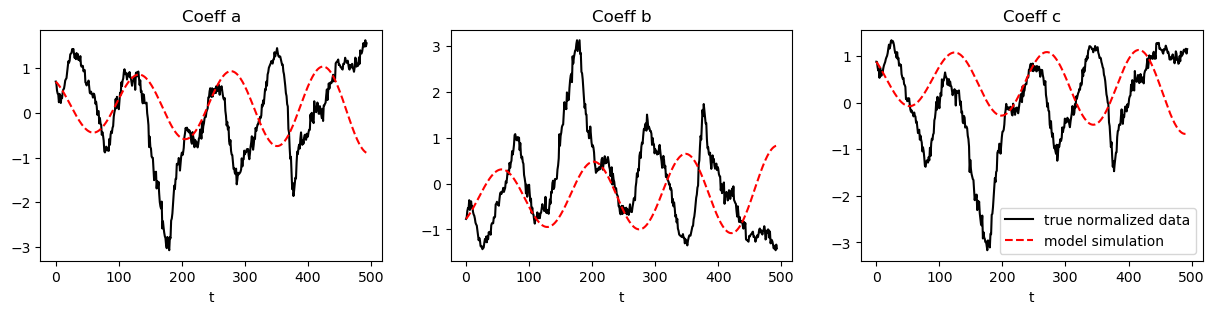

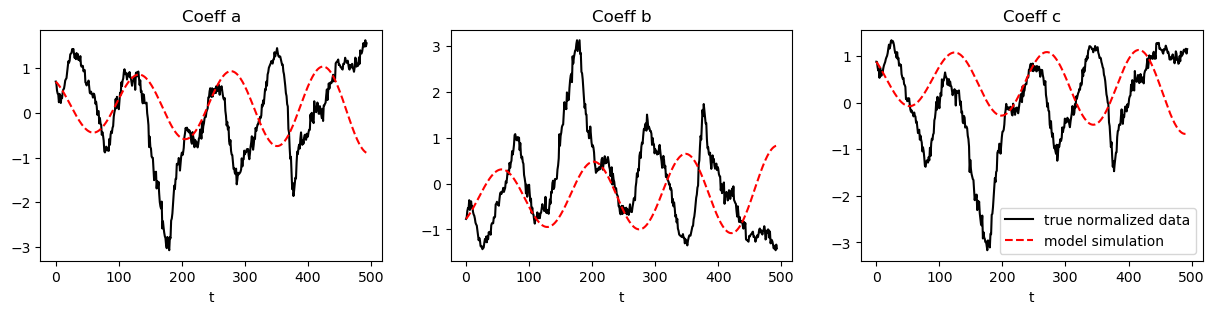

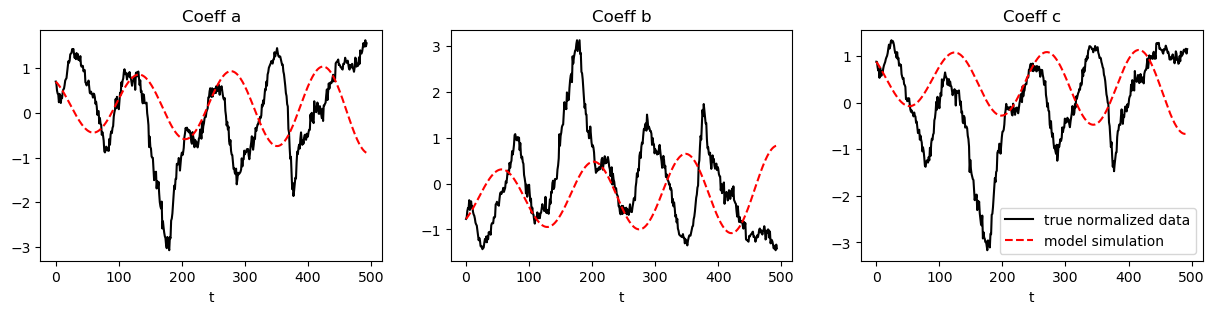

In [11]:
time_series = mean_array
window_length = 5
ensem_thresh = 0.3

ensem_alpha = 1e-3
ensem_max_iter = 200

seed = 1234


np.random.seed(seed)
_, model, X_train, X_train_sim, scalar = sindy_pipeline(time_series = mean_array,
                                                        window_length=window_length,
                                                        ensem_thresh = ensem_thresh,
                                                        ensem_alpha=ensem_alpha,
                                                        ensem_max_iter=ensem_max_iter)
np.random.seed(seed)
_, model, X_train, X_train_sim, scalar = sindy_pipeline(time_series = mean_array,
                                                        window_length=window_length,
                                                        ensem_thresh = ensem_thresh,
                                                        ensem_alpha=ensem_alpha,
                                                        ensem_max_iter=ensem_max_iter)
np.random.seed(seed)
_, model, X_train, X_train_sim, scalar = sindy_pipeline(time_series = mean_array,
                                                        window_length=window_length,
                                                        ensem_thresh = ensem_thresh,
                                                        ensem_alpha=ensem_alpha,
                                                        ensem_max_iter=ensem_max_iter)

In [12]:
model.print()

(a)' = -1.220 a + -1.883 b + -0.691 c
(b)' = 1.174 a + 1.799 b + 0.658 c
(c)' = -1.048 a + -1.590 b + -0.578 c


In [13]:
np.median(model.coef_list, axis=0)

array([[ 0.        , -1.25227378, -1.93358032, -0.70672093,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.20297288,  1.8499899 ,  0.67619168,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.06389813, -1.61439325, -0.58950971,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [14]:
np.mean(model.coef_list,axis=0)

array([[ 0.        , -1.23426035, -1.90557819, -0.69905239,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.1868133 ,  1.82236025,  0.66668118,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.04666067, -1.59036581, -0.58054089,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [15]:
model.coefficients()

array([[ 0.        , -1.22046739, -1.88273459, -0.69107894,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.17393429,  1.79884169,  0.65761026,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.04798334, -1.58993511, -0.57790539,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [16]:
model.print()

(a)' = -1.220 a + -1.883 b + -0.691 c
(b)' = 1.174 a + 1.799 b + 0.658 c
(c)' = -1.048 a + -1.590 b + -0.578 c


## Stabalizing SINDy

In [17]:
model.coef_list

[array([[ 0.        , -1.29155093, -2.00261105, -0.74115162,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.23768339,  1.900552  ,  0.70086134,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -1.05314257, -1.60683784, -0.59348058,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
 array([[ 0.        , -1.21165924, -1.88708403, -0.69463734,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.16128988,  1.78533631,  0.66027321,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -1.0224253 , -1.53436764, -0.55846411,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
 array([[ 0.        , -1.13019798, -1.73161551, -0.6224043 ,  0.        ,
          0.        ,  0.   

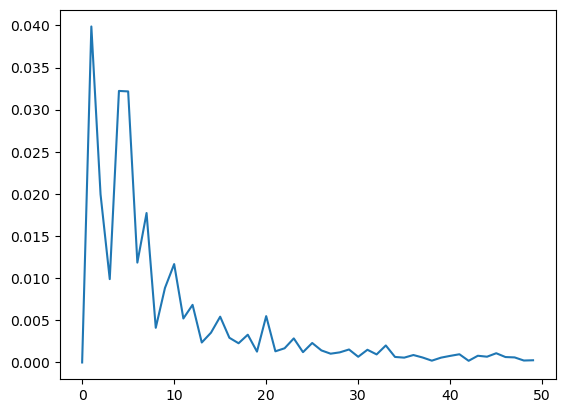

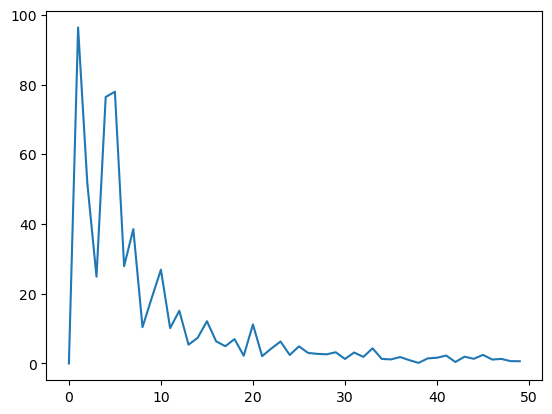

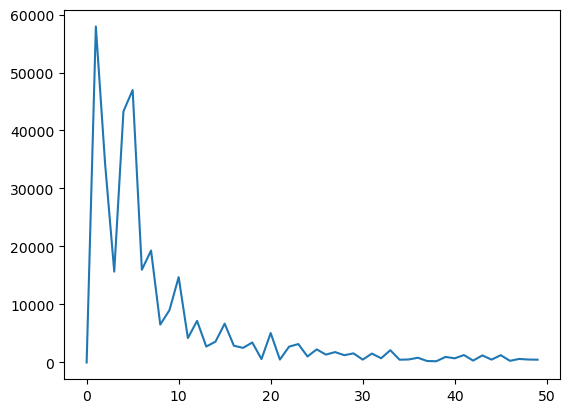

In [29]:
for i in range(3):
    plt.plot(np.abs(np.fft.rfft(mean_array[:,i]-np.mean(mean_array[:,i])))[:50])
    plt.show()

### plot normalized coefficients and learned derivatives

In [18]:
# t = np.array([i for i in range(len(mean_array))])
# scalar = StandardScaler()
# normalized_mean_array = scalar.fit_transform(mean_array)

# thresh = 0.1
# feature_names = ['a', 'b', 'c']
# smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws = {'window_length': 5})

# ensemble_optimizer = ps.STLSQ(threshold=thresh, alpha = 1e-3, max_iter=200)
# model = ps.SINDy(feature_names=feature_names,
#                 optimizer=ensemble_optimizer,
#                 differentiation_method=smoothed_fd)
# model.fit(normalized_mean_array,t=t, ensemble=True,quiet=True)
# model.print()

In [19]:
# smoothed_fd = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 8})

# x_dot = smoothed_fd._differentiate(normalized_mean_array, t)

# # Create a 2x2 grid of subplots
# fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# # Plot the first set of data (a and a') in the first subplot
# axs[0, 0].plot(t, normalized_mean_array[:,0], label="a")
# axs[0, 0].plot(t, x_dot[:,0], label="a'")
# axs[0, 0].legend()

# # Plot the second set of data (b and b') in the second subplot
# axs[0, 1].plot(t, normalized_mean_array[:,1], label="b")
# axs[0, 1].plot(t, x_dot[:,1], label="b'")
# axs[0, 1].legend()

# # Plot the third set of data (c and c') in the third subplot
# axs[1, 0].plot(t, normalized_mean_array[:,2], label="c")
# axs[1, 0].plot(t, x_dot[:,2], label="c'")
# axs[1, 0].legend()

# # Hide the empty fourth subplot
# axs[1, 1].axis('off')

# fig.suptitle('Coefficients and Learned Derivatives', fontsize=16)

# # Adjust layout and display the subplot
# plt.tight_layout()
# plt.show()

In [20]:
plume_learner.frame_height

1080

In [21]:
plume_learner.frame_width

1920

In [22]:
mean_array.shape

(494, 3)